In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.analysis.ap import apdbCassandra
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize, ManualInterval, AsinhStretch
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, MinMaxInterval, LogStretch

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Imports 

In [2]:
i1 = 7436
i2 = 7565
# why this sometimes takes so long 
# find which ones are variable
df_single_ps1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i1)+'.parquet')
df_single_ps2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps = pd.concat([df_single_ps1, df_single_ps2], ignore_index=True)

df_single_ps1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i1)+'.parquet')
df_single_ps2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux], ignore_index=True)

#df_single_sso = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/sso_'+str(i)+'.parquet')
#df_single_gal = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i)+'.parquet')
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]


ra_min =215.60
ra_max = 216.40
dec_min = -12.90
dec_max = -12.15

# Apply the filter to the dataframe
tru_var_obj = df_single_ps_var[
    (df_single_ps_var['ra'] >= ra_min) & (df_single_ps_var['ra'] <= ra_max) &
    (df_single_ps_var['dec'] >= dec_min) & (df_single_ps_var['dec'] <= dec_max)]

In [3]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

In [4]:
def plotFlagImages(exp, flagList=['NO_DATA', 'DETECTED', 'DETECTED_NEGATIVE', 'STREAK']):
    fig = plt.figure(figsize=(24,8))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im

In [5]:
def estimate_purity_completness(df_obj, tru_obj, match_value = 1):
    """Estimate the purity and completness of the detected objects
    
        Parameters
    ----------
    obj4_field : `pd.dataframe`
        Detected objects
    tru_obj : `pd.dataframe`
        True variable objects
    match_value : `float`
        matching radius in arcsec    
    
    Returns
    -------
    purity, completeness  : `float`, `float`
        Purity and completness
    """

    # all of the diaObjects in a field
    dia_obj_SC = SkyCoord(ra=df_obj['ra'].values*u.degree, dec=df_obj['dec'].values*u.degree) 
    # all of the variable objects in a field
    tru_obj_SC = SkyCoord(ra=tru_obj['ra'].values*u.degree, dec=tru_obj['dec'].values*u.degree)
    # match the observations to the truth
    idx, d2d, d3d = tru_obj_SC.match_to_catalog_sky(dia_obj_SC)
    # index of all diaObj that are within match_value of a true variable object
    idx_close = idx[d2d.to(u.arcsec).value<match_value]

    # all of diaObjects thare are within match_value of a variable object
    matches_close = df_obj.iloc[idx_close]

    # fraction of dia Objects that are actually near a variable objects 
    purity = len(matches_close)/len(df_obj)

    # fraction of variable objects that have been detected 
    completnes = len(matches_close)/len(tru_obj_SC)

    return purity, completnes

In [64]:
repo = 'embargo_or4'

instrument = 'LSSTComCamSim'
schema =  f'pp_ppdb_lsstcomcamsim_or4'
butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
# skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

schema_dm46333F2 = 'pp_ppdb_dm46333F2'
apdbQuery_dm46333F2 = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema_dm46333F2)


In [7]:
ra_min = 215.6
ra_max = 216.4
dec_min = -12.9
dec_max = -12.15

ra_min_in_rad = (ra_min*u.deg).to(u.rad).value
ra_max_in_rad = (ra_max*u.deg).to(u.rad).value
dec_min_in_rad = (dec_min*u.deg).to(u.rad).value
dec_max_in_rad = (dec_max*u.deg).to(u.rad).value


In [8]:
with apdbQuery.connection as connection:
    src4_field = pd.read_sql_query(f'''
        SELECT 
            "diaSourceId", 
            "diaObjectId", 
            "ra", 
            "dec", 
            "raErr", 
            "decErr", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "snr", 
            "band", 
            "visit",
            "detector",	
            "x",
            "xErr",
            "y",
            "yErr",
            "time_processed", 
            "time_withdrawn",
            "isDipole",
            "centroid_flag",
            "apFlux_flag",
            "apFlux_flag_apertureTruncated",
            "psfFlux_flag",
            "psfFlux_flag_edge",
            "psfFlux_flag_noGoodPixels",
            "trail_flag_edge",
            "forced_PsfFlux_flag",
            "forced_PsfFlux_flag_edge",
            "forced_PsfFlux_flag_noGoodPixels",
            "shape_flag",
            "shape_flag_no_pixels",
            "shape_flag_not_contained",
            "shape_flag_parent_source",
            "pixelFlags",
            "pixelFlags_bad",
            "pixelFlags_cr",
            "pixelFlags_crCenter",
            "pixelFlags_edge",
            "pixelFlags_interpolated",
            "pixelFlags_interpolatedCenter",
            "pixelFlags_offimage",
            "pixelFlags_saturated",
            "pixelFlags_saturatedCenter",
            "pixelFlags_suspect",
            "pixelFlags_suspectCenter",
            "pixelFlags_streak",
            "pixelFlags_streakCenter",
            "pixelFlags_injected",
            "pixelFlags_injectedCenter",
            "pixelFlags_injected_template",
            "pixelFlags_injected_templateCenter",
            "reliability"
        FROM "{schema}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [67]:
with apdbQuery_dm46333F2.connection as connection:
    src4_field_dm46333F2 = pd.read_sql_query(f'''
        SELECT 
            "diaSourceId", 
            "diaObjectId", 
            "ra", 
            "dec", 
            "raErr", 
            "decErr", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "snr", 
            "band", 
            "visit",
            "detector",	
            "x",
            "xErr",
            "y",
            "yErr",
            "time_processed", 
            "time_withdrawn",
            "isDipole",
            "centroid_flag",
            "apFlux_flag",
            "apFlux_flag_apertureTruncated",
            "psfFlux_flag",
            "psfFlux_flag_edge",
            "psfFlux_flag_noGoodPixels",
            "trail_flag_edge",
            "forced_PsfFlux_flag",
            "forced_PsfFlux_flag_edge",
            "forced_PsfFlux_flag_noGoodPixels",
            "shape_flag",
            "shape_flag_no_pixels",
            "shape_flag_not_contained",
            "shape_flag_parent_source",
            "pixelFlags",
            "pixelFlags_bad",
            "pixelFlags_cr",
            "pixelFlags_crCenter",
            "pixelFlags_edge",
            "pixelFlags_interpolated",
            "pixelFlags_interpolatedCenter",
            "pixelFlags_offimage",
            "pixelFlags_saturated",
            "pixelFlags_saturatedCenter",
            "pixelFlags_suspect",
            "pixelFlags_suspectCenter",
            "pixelFlags_streak",
            "pixelFlags_streakCenter",
            "pixelFlags_injected",
            "pixelFlags_injectedCenter",
            "pixelFlags_injected_template",
            "pixelFlags_injected_templateCenter",
            "reliability"
        FROM "{schema_dm46333F2}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [9]:
with apdbQuery.connection as connection:
    srcForced4_field = pd.read_sql_query(f'''
        SELECT 
            "diaForcedSourceId", 
            "diaObjectId", 
            "ra", 
            "dec",
            "visit",
            "detector", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "band"
        FROM "{schema}"."DiaForcedSource"
        WHERE "ra" BETWEEN {ra_min_in_rad} AND {ra_max_in_rad}
        AND "dec" BETWEEN {dec_min_in_rad} AND {dec_max_in_rad}
        LIMIT 3000000;
    ''', connection)
    
srcForced4_field['ra'] = radians_to_degrees(srcForced4_field['ra'].values)
srcForced4_field['dec'] = radians_to_degrees(srcForced4_field['dec'].values)

In [65]:
#latest = False does not work
or4_obj = apdbQuery.load_objects(limit=1e7, latest=True)
or4_obj_dm46333F2 = apdbQuery_dm46333F2.load_objects(limit=1e7, latest=True)
# We got all of them, less than 1e7 here
assert len(or4_obj) < 1e7
assert len(or4_obj_dm46333F2) < 1e7

In [66]:
print(len(or4_obj))
print(len(or4_obj_dm46333F2))

1429486
109585


In [11]:
# only Cassandra for recent reprocessing 
or4_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='file:///sdf/home/s/sullii/project/tickets/DM-46333F/dm46333F2-config.py')

INFO:cassandra.cluster:New Cassandra host <Host: 172.24.4.176:9042 datacenter1> discovered
INFO:cassandra.cluster:New Cassandra host <Host: 172.24.4.173:9042 datacenter1> discovered
INFO:cassandra.cluster:New Cassandra host <Host: 172.24.4.172:9042 datacenter1> discovered
INFO:cassandra.cluster:New Cassandra host <Host: 172.24.4.175:9042 datacenter1> discovered


# DM - 46125

In [84]:
repo = 'embargo_or4'
instrument = 'LSSTComCamSim'
pp_collections = ['LSSTComCamSim/prompt/output-2024-06-25', 'LSSTComCamSim/prompt/output-2024-06-26', 'LSSTComCamSim/prompt/output-2024-06-27']
# pp_collections = ['u/sullii/DM-46333/OR4/association', 'u/sullii/DM-46333/OR4/noDiaPipe']
pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)

pp_collections_dm46333F2 = 'u/sullii/DM-46333/OR4/regionLevel11_centroidFix2'
pp_butler_dm46333F2 = dafButler.Butler(repo, collections=pp_collections_dm46333F2, instrument=instrument)

In [13]:
# Get column names for the DiaSource table
"""
column_obj_names = or4_apdb_Cassandra._apdb._schema.apdbColumnNames(ApdbTables.DiaObject)

query_obj = or4_apdb_Cassandra._build_query(
    ApdbTables.DiaObject,
    columns=column_obj_names,
    where='ra >= 200 AND ra <= 230 AND dec >= -16 AND dec <= -10',
    limit=100000  # Adjust the limit as needed, or remove for no limit
)

# Prepare and execute the query
statement_obj = or4_apdb_Cassandra._apdb._preparer.prepare(query_obj)
result_obj = or4_apdb_Cassandra._apdb._session.execute(
    statement_obj,
    timeout=200,
    execution_profile="read_pandas"
)

# Convert the result to a pandas DataFrame
obj4_field_Cassandra = cast(pd.DataFrame, result_obj._current_rows)
print(len(obj4_field_Cassandra))

column_names = or4_apdb_Cassandra._apdb._schema.apdbColumnNames(ApdbTables.DiaSource)
# Build the query for the specified ra and dec range
query = or4_apdb_Cassandra._build_query(
    ApdbTables.DiaSource,
    columns=column_names,
    where='ra >= 200 AND ra <= 230 AND dec >= -16 AND dec <= -10',
    limit=100000  # Adjust the limit as needed, or remove for no limit
)

# Prepare and execute the query
statement = or4_apdb_Cassandra._apdb._preparer.prepare(query)
result = or4_apdb_Cassandra._apdb._session.execute(
    statement,
    timeout=200,
    execution_profile="read_pandas"
)

# Convert the result to a pandas DataFrame
src4_field_Cassandra = cast(pd.DataFrame, result._current_rows)
print(len(src4_field_Cassandra))
"""



35986
35986


In [68]:
# lets look at only one field
# objects
obj4_field = or4_obj[(or4_obj['ra'] > ra_min) & (or4_obj['ra'] < ra_max) & (or4_obj['dec'] > dec_min) & (or4_obj['dec'] < dec_max)]
obj4_field_dm46333F2 = or4_obj_dm46333F2[(or4_obj_dm46333F2['ra'] > ra_min) & (or4_obj_dm46333F2['ra'] < ra_max) &\
    (or4_obj_dm46333F2['dec'] > dec_min) & (or4_obj_dm46333F2['dec'] < dec_max)]

In [15]:
"""
obj4_Cas_field = obj4_field_Cassandra[(obj4_field_Cassandra['ra'] > ra_min) & (obj4_field_Cassandra['ra'] < ra_max) \
    & (obj4_field_Cassandra['dec'] > dec_min) & (obj4_field_Cassandra['dec'] < dec_max)]

src4_Cas_field = src4_field_Cassandra[(src4_field_Cassandra['ra'] > ra_min) & (src4_field_Cassandra['ra'] < ra_max) \
    & (src4_field_Cassandra['dec'] > dec_min) & (src4_field_Cassandra['dec'] < dec_max)]
"""

In [69]:
print(len(obj4_field))
print(len(obj4_field_dm46333F2))

9942
1600


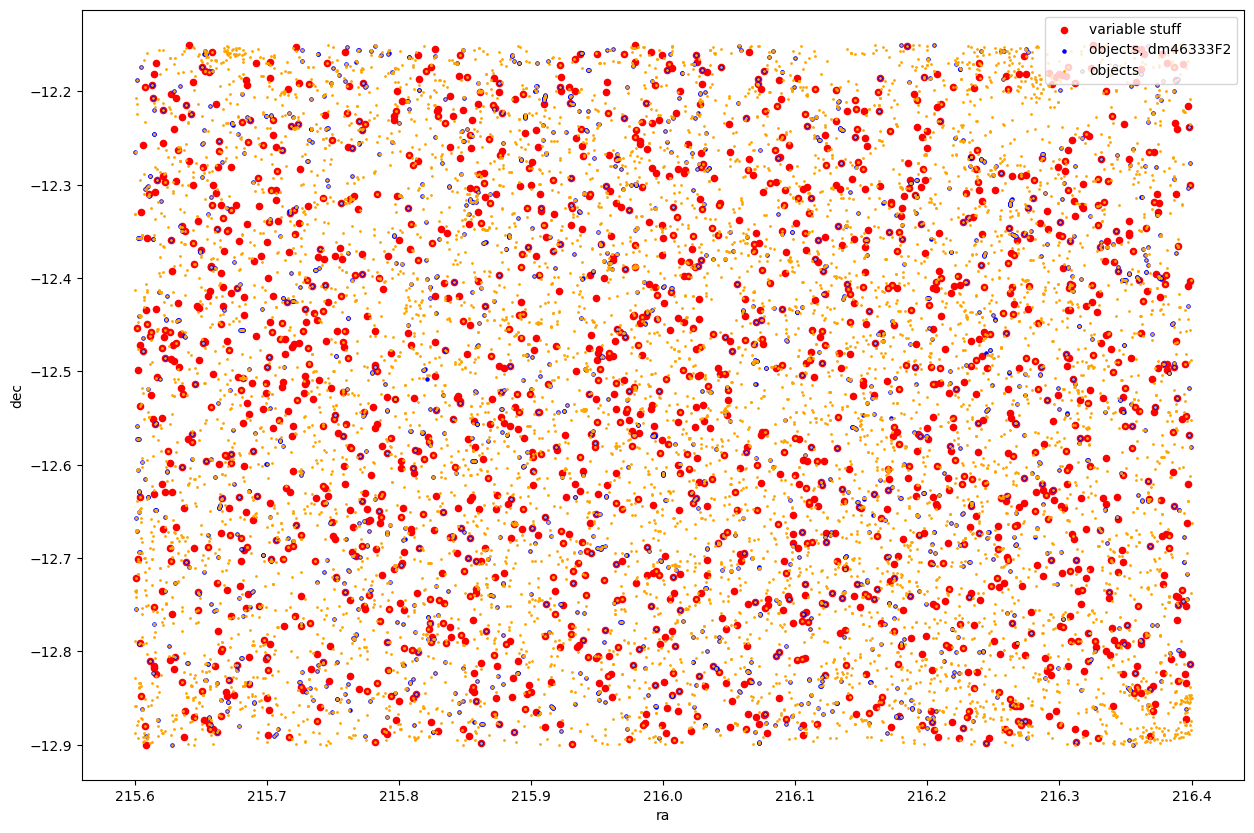

In [72]:
plt.figure(figsize=(15,10))

plt.scatter(tru_var_obj['ra'],tru_var_obj['dec'], color = 'red', label = 'variable stuff', s=20)
plt.scatter(obj4_field_dm46333F2['ra'],obj4_field_dm46333F2['dec'], s=5, color = 'blue', label = 'objects, dm46333F2')
plt.scatter(obj4_field['ra'],obj4_field['dec'], s=1, color = 'orange', label = 'objects')

plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

In [135]:
# latest rerun
print(estimate_purity_completness(obj4_field_dm46333F2, tru_var_obj))
# original data
print(estimate_purity_completness(obj4_field, tru_var_obj))
# Cassandra
print(estimate_purity_completness(src4_field_dm46333F2, tru_var_obj))

(0.183125, 0.1652566271855612)
(0.07624220478776907, 0.4275239706711788)
(0.009585914574502771, 0.1658206429780034)


In [20]:
list_datasets = list(set(pp_butler.registry.queryDatasets('goodSeeingDiff_assocDiaSrc',  where="instrument='LSSTComCamSim'",  collections=pp_collections)))
# Extract relevant fields: 'detector', 'visit', 'band'
extracted_info = [(item.dataId['detector'], item.dataId['visit'], item.dataId['band']) for item in list_datasets]
extracted_info = pd.DataFrame(extracted_info, columns=['detector', 'visit', 'band']).sort_values(by='visit')
# all the visits in OR4
list_of_visits = (np.unique(extracted_info['visit']))

In [21]:
# visit which exists in the source table but not in goodSeeingDiff_assocDiaSrc table?
# this is just to make sure we are not missing anything
# empty in new rerurns
np.setxor1d( np.intersect1d(src4_field['visit'].unique(),list_of_visits),src4_field['visit'].unique())

array([], dtype=int64)

In [76]:
# obj that have nan as raErr or decErr
obj4_field_nan = obj4_field[pd.isna(obj4_field['raErr'])]
# obj that have actual values as raErr or decErr
obj4_field_not_nan = obj4_field[pd.notna(obj4_field['raErr'])]

# so many object have nan values for raErr and decErr
print(len(obj4_field_not_nan))
print(len(obj4_field_nan))


obj4_field_dm46333F2_nan = obj4_field_dm46333F2[pd.isna(obj4_field_dm46333F2['raErr'])]
# obj that have actual values as raErr or decErr
obj4_field_dm46333F2_not_nan = obj4_field_dm46333F2[pd.notna(obj4_field_dm46333F2['raErr'])]

# so many object have nan values for raErr and decErr
print(len(obj4_field_dm46333F2_not_nan))
print(len(obj4_field_dm46333F2_nan))

5876
4066
1109
491


In [23]:
# select a single object from initial run 
single_obj = obj4_field_nan[obj4_field_nan['nDiaSources'] > 10].iloc[23]
single_obj = obj4_field_not_nan[obj4_field_not_nan['nDiaSources'] > 10].iloc[230]
single_obj

diaObjectId                       3068394109518479458
validityStart               2024-06-26 02:56:11+00:00
validityEnd                                      None
ra                                         216.165437
raErr                                        0.000008
                                      ...            
y_psfFluxLinearIntercept                         None
y_psfFluxMaxSlope                                None
y_psfFluxErrMean                                 None
lastNonForcedSource         2024-06-26 02:55:46+00:00
nDiaSources                                        19
Name: 154061, Length: 190, dtype: object

In [77]:
# select all sources for this object
src_for_single_obj = src4_field[(src4_field['diaObjectId']==single_obj['diaObjectId']) ]
# print ra and dec
print(src_for_single_obj['diaSourceId'].values[0], src_for_single_obj['ra'].values[0], src_for_single_obj['dec'].values[0])

3068394109518479458 216.16532087735004 -12.71539803680108


In [78]:
# select a single source
# 0 - dipol
# 1 - not a dipol
id = 1
single_src_id = src_for_single_obj['diaSourceId'].values[id]
print(single_src_id)

3068394111653380230


In [79]:
# selector boolean array
select_single = src_for_single_obj['diaSourceId']==single_src_id
select_single

152      False
1448      True
10758    False
21982    False
25305    False
27819    False
29637    False
33789    False
35253    False
36094    False
38357    False
39371    False
45887    False
47081    False
48372    False
52996    False
54453    False
55953    False
57543    False
Name: diaSourceId, dtype: bool

(7024062500092.0, 7024062500292.0)

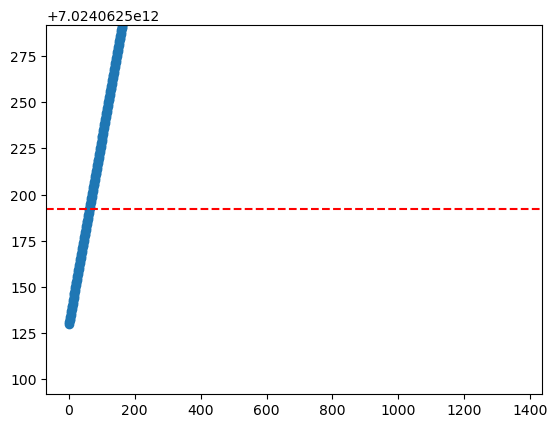

In [80]:
plt.scatter(np.arange(len(list_of_visits)), list_of_visits)
plt.axhline(src_for_single_obj.loc[select_single,'visit'].values[0], color='r', linestyle='--')  
plt.ylim(src_for_single_obj.loc[select_single,'visit'].values[0] - 100 , src_for_single_obj.loc[select_single,'visit'].values[0] + 100)

In [81]:
# position of the source
center = lsst.geom.SpherePoint(src_for_single_obj.loc[select_single,'ra'], src_for_single_obj.loc[select_single,'dec'] , lsst.geom.degrees)
center

SpherePoint(216.1654858234385*degrees, -12.715462918092289*degrees)

In [85]:
extent = lsst.geom.Extent2I(200, 200)
data1= {'detector': src_for_single_obj.loc[select_single,'detector'].values[0], 'visit': src_for_single_obj.loc[select_single,'visit'].values[0]}

src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)

one_pp_science = pp_butler.get('initial_pvi', dataId=data1)
one_pp_template = pp_butler.get('goodSeeingDiff_templateExp', dataId=data1)
one_pp_diffim = pp_butler.get('goodSeeingDiff_differenceExp', dataId=data1)

science_cutout = one_pp_science.getCutout(center, extent)
template_cutout = one_pp_template.getCutout(center, extent)
difference_cutout = one_pp_diffim.getCutout(center, extent)

In [86]:
# check that source is there via butler
src_for_single_obj_via_butler = src_via_butler[src_via_butler['diaObjectId'] == src_for_single_obj['diaObjectId'].values[id]]
src_for_single_obj_via_butler

,,,diaSourceId,visit,detector,diaObjectId,ssObjectId,parentDiaSourceId,ssObjectReassocTime,midpointMjdTai,ra,raErr,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,programId
diaObjectId,band,diaSourceId,,,,,,,,,,,,,,,,,,,,,
3068394109518479458,i,3068394111653380230,3068394111653380230,7024062500192,0,3068394109518479458,0,0,NaT,60487.090247,216.165486,0.00001,...,False,False,False,False,False,False,False,False,False,0


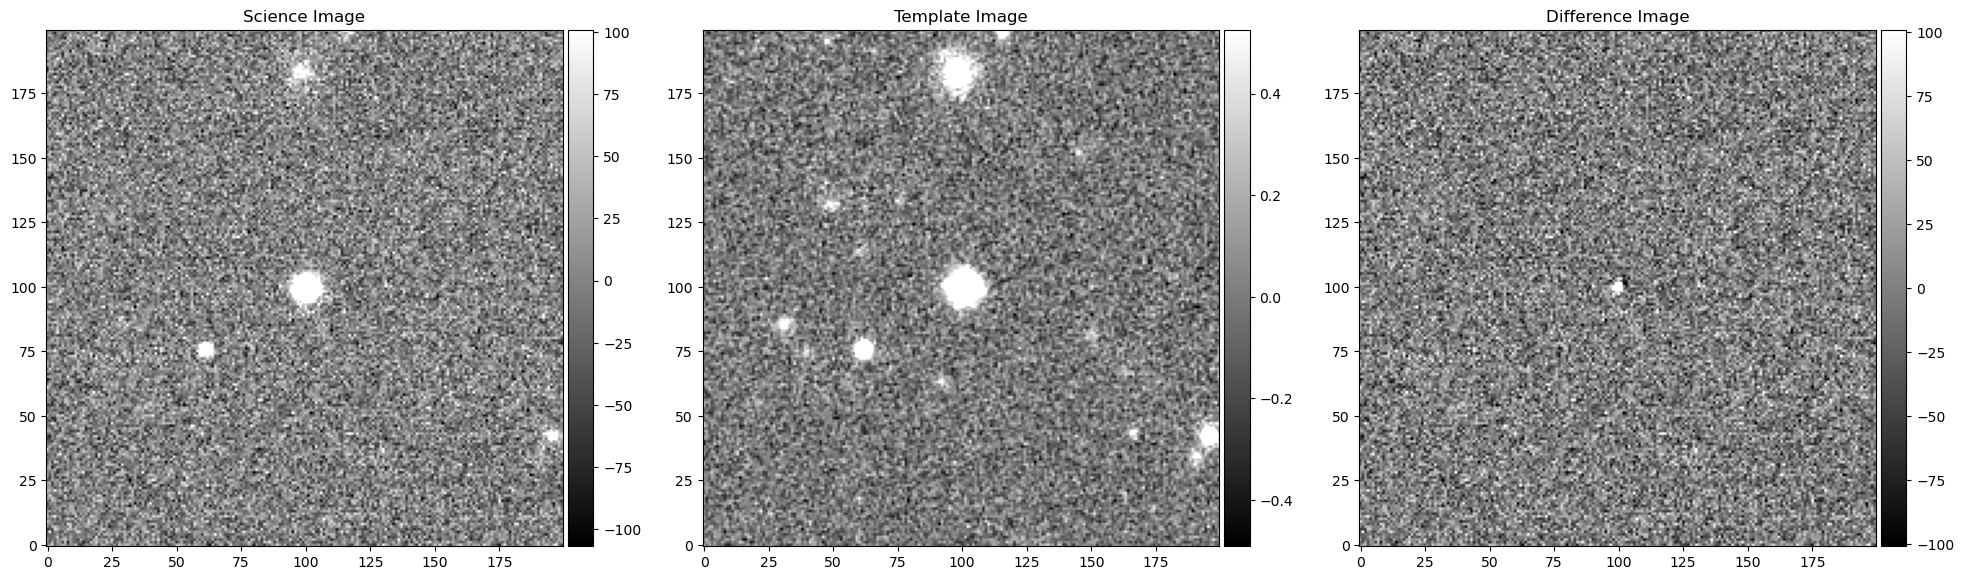

In [87]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_cutout.image.array, interval=ZScaleInterval())
norm_template = ImageNormalize(template_cutout.image.array, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(science_cutout.image.array, origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(template_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(difference_cutout.image.array, origin='lower', norm=norm_diffim, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')

# Show the plot
plt.show()


Text(0.5, 1.0, 'Difference Image')

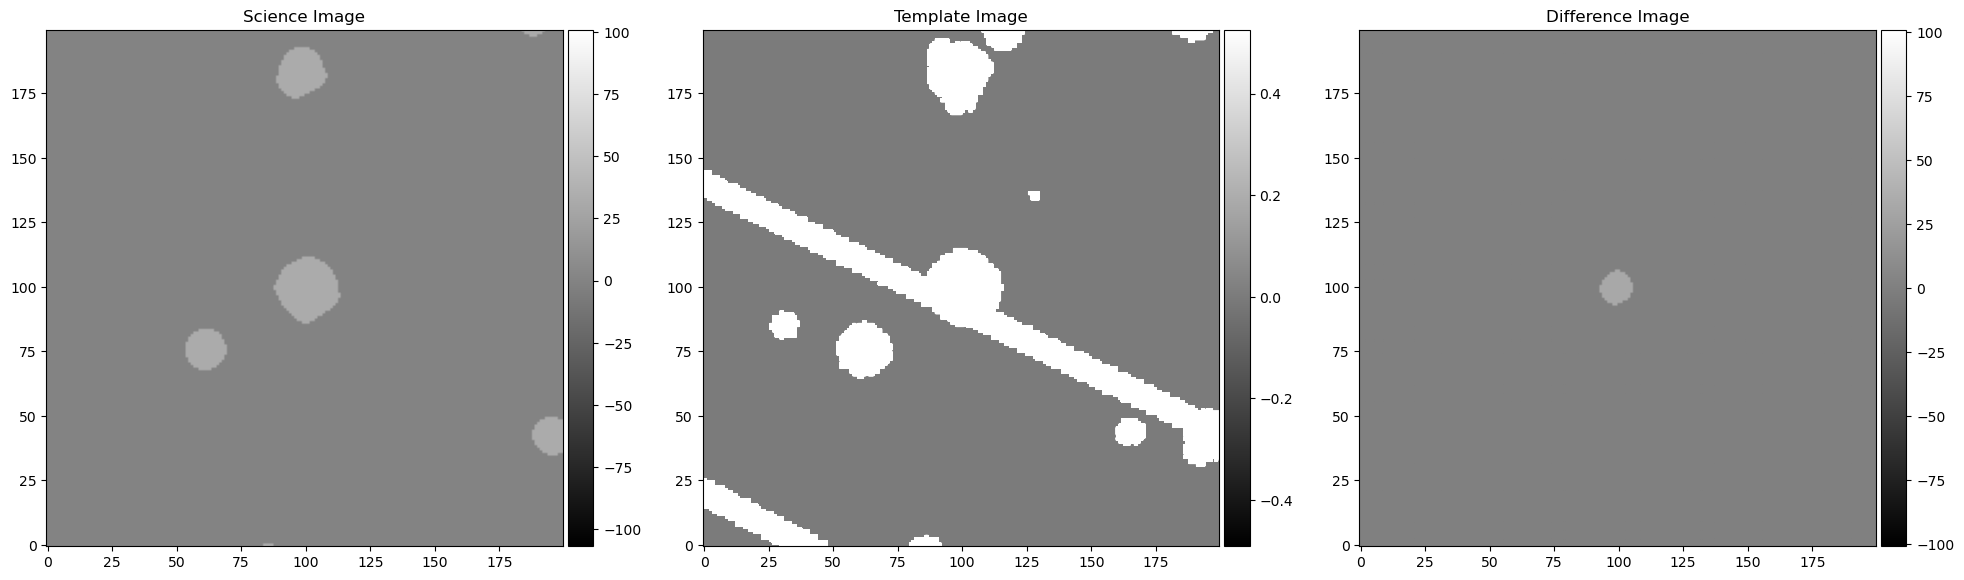

In [88]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_cutout.image.array, interval=ZScaleInterval())
norm_template = ImageNormalize(template_cutout.image.array, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(science_cutout.mask.array, origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(template_cutout.mask.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(difference_cutout.mask.array, origin='lower', norm=norm_diffim, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')


In [116]:
# Reverse the mask dictionary to make it easier to find flag descriptions by bit positions
reverse_mask_dict = {v: k for k, v in mask_dict.items()}

# Get the unique values from the mask array
template_cutout_values = np.unique(template_cutout.mask.array)
difference_cutout_values = np.unique(difference_cutout.mask.array)
science_cutout_values = np.unique(science_cutout.mask.array)

# Function to get the flag descriptions for a given value
def get_flag_descriptions(value, reverse_mask_dict):
    flags = []
    for bit_position, description in reverse_mask_dict.items():
        if value & (1 << bit_position):  # Check if the bit is set
            flags.append(description)
    return flags

# Print flag descriptions for each unique value'
print('Template image')   
for value in template_cutout_values:
    flag_descriptions = get_flag_descriptions(value, reverse_mask_dict)
    print(f"Value: {value} -> Flags: {flag_descriptions}")
print('Difference image')    
for value in difference_cutout_values:
    flag_descriptions = get_flag_descriptions(value, reverse_mask_dict)
    print(f"Value: {value} -> Flags: {flag_descriptions}")
print('Science image')
for value in science_cutout_values:
    flag_descriptions = get_flag_descriptions(value, reverse_mask_dict)
    print(f"Value: {value} -> Flags: {flag_descriptions}")

Template image
Value: 0 -> Flags: []
Value: 12 -> Flags: ['CR', 'INTRP']
Value: 32 -> Flags: ['DETECTED']
Value: 18432 -> Flags: ['INEXACT_PSF', 'SENSOR_EDGE']
Value: 18464 -> Flags: ['DETECTED', 'INEXACT_PSF', 'SENSOR_EDGE']
Difference image
Value: 0 -> Flags: []
Value: 32 -> Flags: ['DETECTED']
Science image
Value: 0 -> Flags: []
Value: 32 -> Flags: ['DETECTED']


In [91]:
def plotFlagImages(exp, flagList=['DETECTED_NEGATIVE', 'DETECTED', 'SENSOR_EDGE', 'INEXACT_PSF']):
    fig = plt.figure(figsize=(24,8))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im

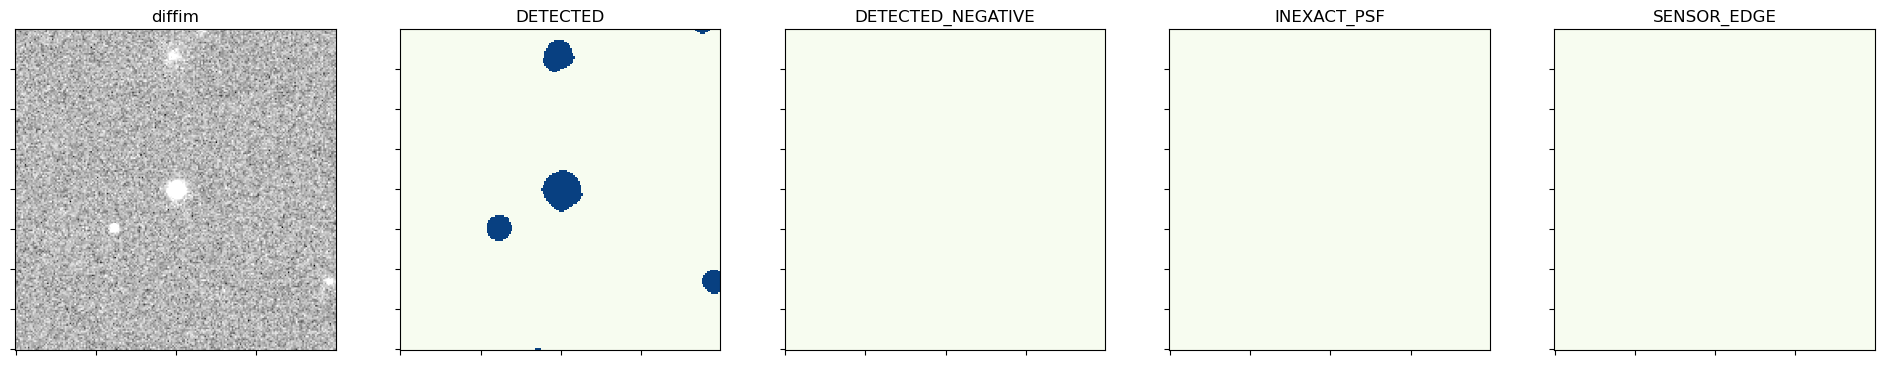

In [94]:
plotFlagImages(science_cutout)

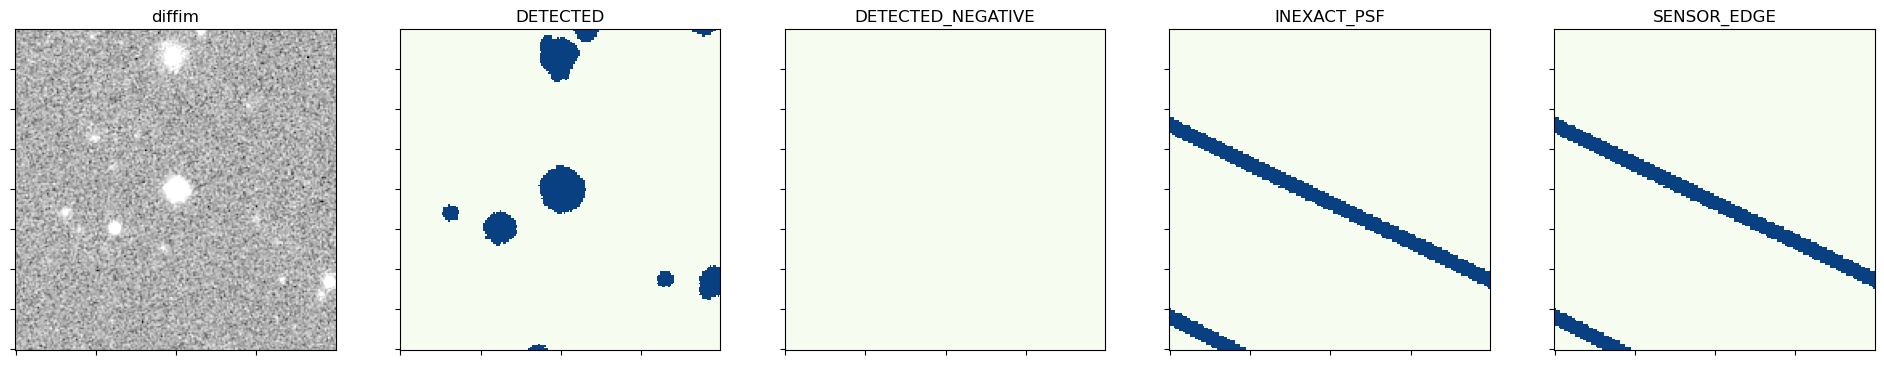

In [95]:
plotFlagImages(template_cutout)

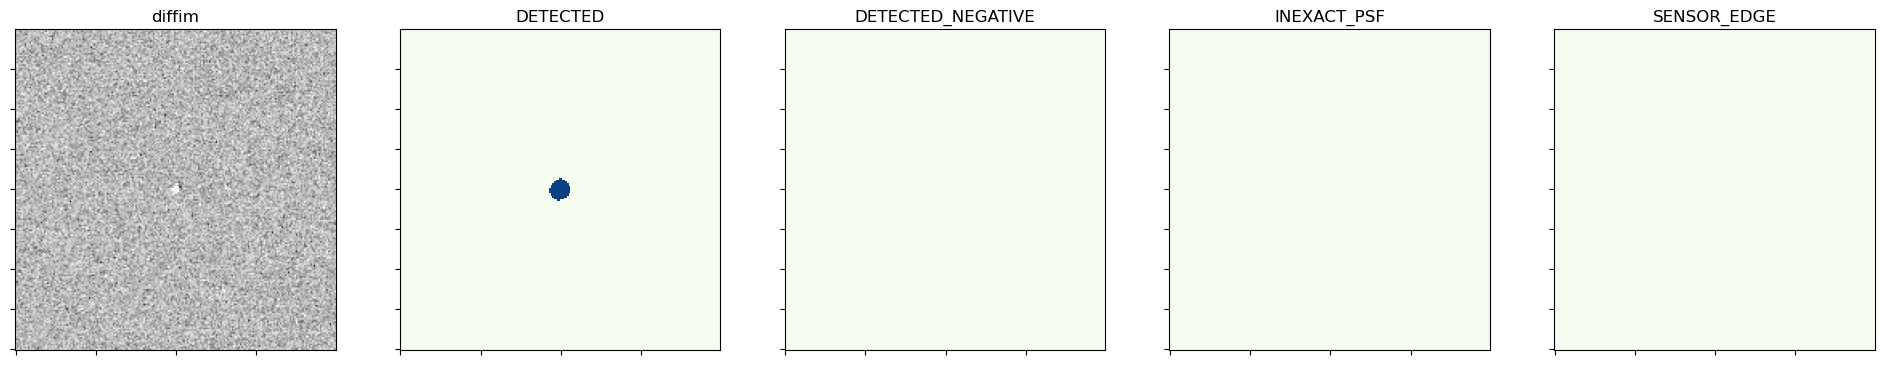

In [96]:
plotFlagImages(difference_cutout)

In [97]:
# select all sources for this object
src_for_single_obj = src4_field[(src4_field['diaObjectId']==single_obj['diaObjectId']) ]
src_for_single_obj[['centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
152,False,False,False,False,True
1448,False,False,False,False,False
10758,True,True,True,True,True
21982,True,True,True,True,True
25305,True,True,True,True,True
27819,False,False,False,False,False
29637,False,False,False,False,True
33789,False,False,False,False,False
35253,False,False,False,False,True
36094,False,False,False,False,False


In [117]:
# example of a source with everything Nan
src_for_single_obj.loc[45887]

diaSourceId                                 3068394170709180481
diaObjectId                                 3068394109518479458
ra                                                   216.165468
dec                                                  -12.715666
raErr                                                       NaN
decErr                                                      NaN
midpointMjdTai                                      60487.11877
psfFlux                                            -1608.145874
psfFluxErr                                           303.842804
scienceFlux                                        61105.542969
scienceFluxErr                                       296.876678
snr                                                    5.301852
band                                                          r
visit                                             7024062500247
detector                                                      0
x                                       

In [131]:
column_names_flags = ["centroid_flag", "apFlux_flag", "apFlux_flag_apertureTruncated", "psfFlux_flag",
            "psfFlux_flag_edge", "psfFlux_flag_noGoodPixels", "trail_flag_edge", "forced_PsfFlux_flag",
            "forced_PsfFlux_flag_edge", "forced_PsfFlux_flag_noGoodPixels", "shape_flag", "shape_flag_no_pixels",
            "shape_flag_not_contained", "shape_flag_parent_source", "pixelFlags", "pixelFlags_bad",
            "pixelFlags_cr", "pixelFlags_crCenter", "pixelFlags_edge", "pixelFlags_interpolated",
            "pixelFlags_interpolatedCenter", "pixelFlags_offimage", "pixelFlags_saturated",
            "pixelFlags_saturatedCenter","pixelFlags_suspect", "pixelFlags_suspectCenter",
            "pixelFlags_streak", "pixelFlags_streakCenter", "pixelFlags_injected", "pixelFlags_injectedCenter", 
            "pixelFlags_injected_template", "pixelFlags_injected_templateCenter"]

In [133]:
# Assuming your DataFrame is named src_for_single_obj
# And your flag column names are in column_names_flags

# Function to calculate the fraction of activated rows for each flag
def calculate_flag_fractions(df, flag_columns):
    flag_fractions = {}
    
    for flag in flag_columns:
        if flag in df.columns:  # Ensure the flag exists in the DataFrame
            # Calculate fraction: number of activated rows (True or 1) / total rows
            fraction_activated = df[flag].mean()
            flag_fractions[flag] = fraction_activated
        else:
            print(f"Warning: {flag} not found in the DataFrame")
    
    return flag_fractions

# Calculate fractions for the flags
flag_fractions = calculate_flag_fractions(src4_field, column_names_flags)

# Print the result
for flag, fraction in flag_fractions.items():
    print(f"{flag}: {fraction:.2%} rows have this flag activated")

centroid_flag: 29.19% rows have this flag activated
apFlux_flag: 28.90% rows have this flag activated
apFlux_flag_apertureTruncated: 0.00% rows have this flag activated
psfFlux_flag: 28.90% rows have this flag activated
psfFlux_flag_edge: 1.06% rows have this flag activated
psfFlux_flag_noGoodPixels: 0.00% rows have this flag activated
trail_flag_edge: 0.00% rows have this flag activated
forced_PsfFlux_flag: 28.90% rows have this flag activated
forced_PsfFlux_flag_edge: 1.06% rows have this flag activated
forced_PsfFlux_flag_noGoodPixels: 0.00% rows have this flag activated
shape_flag: 50.30% rows have this flag activated
shape_flag_no_pixels: 0.00% rows have this flag activated
shape_flag_not_contained: 0.00% rows have this flag activated
shape_flag_parent_source: 0.00% rows have this flag activated
pixelFlags: 0.00% rows have this flag activated
pixelFlags_bad: 0.00% rows have this flag activated
pixelFlags_cr: 0.01% rows have this flag activated
pixelFlags_crCenter: 0.00% rows have 

In [134]:
# Calculate fractions for the flags
flag_fractions = calculate_flag_fractions(src4_field_dm46333F2, column_names_flags)

# Print the result
for flag, fraction in flag_fractions.items():
    print(f"{flag}: {fraction:.2%} rows have this flag activated")

centroid_flag: 7.59% rows have this flag activated
apFlux_flag: 7.61% rows have this flag activated
apFlux_flag_apertureTruncated: 0.03% rows have this flag activated
psfFlux_flag: 7.84% rows have this flag activated
psfFlux_flag_edge: 0.79% rows have this flag activated
psfFlux_flag_noGoodPixels: 0.00% rows have this flag activated
trail_flag_edge: 0.00% rows have this flag activated
forced_PsfFlux_flag: 7.84% rows have this flag activated
forced_PsfFlux_flag_edge: 0.79% rows have this flag activated
forced_PsfFlux_flag_noGoodPixels: 0.00% rows have this flag activated
shape_flag: 21.17% rows have this flag activated
shape_flag_no_pixels: 0.00% rows have this flag activated
shape_flag_not_contained: 0.00% rows have this flag activated
shape_flag_parent_source: 0.00% rows have this flag activated
pixelFlags: 0.00% rows have this flag activated
pixelFlags_bad: 1.36% rows have this flag activated
pixelFlags_cr: 0.00% rows have this flag activated
pixelFlags_crCenter: 0.00% rows have this

In [152]:
print(len(src4_field_dm46333F2[(src4_field['isDipole'] == False)]))
print(len(src4_field_dm46333F2[(np.isnan(src4_field['raErr'])) ]))

nan_data_no_dipole = src4_field_dm46333F2[(np.isnan(src4_field_dm46333F2['raErr'])) & (src4_field_dm46333F2['isDipole'] == False)]
print(len(nan_data_no_dipole))

# Calculate fractions for the flags
flag_fractions = calculate_flag_fractions(nan_data_no_dipole, column_names_flags)

# Print the result
for flag, fraction in flag_fractions.items():
    print(f"{flag}: {fraction:.2%} rows have this flag activated")

21617
8546
1898
centroid_flag: 100.00% rows have this flag activated
apFlux_flag: 100.00% rows have this flag activated
apFlux_flag_apertureTruncated: 0.00% rows have this flag activated
psfFlux_flag: 100.00% rows have this flag activated
psfFlux_flag_edge: 3.64% rows have this flag activated
psfFlux_flag_noGoodPixels: 0.00% rows have this flag activated
trail_flag_edge: 0.00% rows have this flag activated
forced_PsfFlux_flag: 100.00% rows have this flag activated
forced_PsfFlux_flag_edge: 3.64% rows have this flag activated
forced_PsfFlux_flag_noGoodPixels: 0.00% rows have this flag activated
shape_flag: 100.00% rows have this flag activated
shape_flag_no_pixels: 0.00% rows have this flag activated
shape_flag_not_contained: 0.00% rows have this flag activated
shape_flag_parent_source: 0.00% rows have this flag activated
pixelFlags: 0.00% rows have this flag activated
pixelFlags_bad: 4.16% rows have this flag activated
pixelFlags_cr: 0.00% rows have this flag activated
pixelFlags_crCen

In [155]:
single_src = nan_data_no_dipole.iloc[100]
single_src

diaSourceId                                        3068394120260092004
diaObjectId                                        3068394109531062339
ra                                                          216.068989
dec                                                         -12.471048
raErr                                                              NaN
decErr                                                             NaN
midpointMjdTai                                            60487.093996
psfFlux                                                     -148068.75
psfFluxErr                                                 1029.305298
scienceFlux                                                909083.8125
scienceFluxErr                                              992.040466
snr                                                         144.644318
band                                                                 i
visit                                                    7024062500200
detect

In [162]:
extent = lsst.geom.Extent2I(200, 200)
data1= {'detector': single_src['detector'], 'visit': single_src['visit']}

src_via_butler = pp_butler_dm46333F2.get('goodSeeingDiff_assocDiaSrc', dataId=data1)

one_pp_science = pp_butler_dm46333F2.get('initial_pvi', dataId=data1)
one_pp_template = pp_butler_dm46333F2.get('goodSeeingDiff_templateExp', dataId=data1)
one_pp_diffim = pp_butler_dm46333F2.get('goodSeeingDiff_differenceExp', dataId=data1)

science_cutout = one_pp_science.getCutout(center, extent)
template_cutout = one_pp_template.getCutout(center, extent)
difference_cutout = one_pp_diffim.getCutout(center, extent)

InvalidParameterError: 
  File "src/image/Exposure.cc", line 221, in lsst::afw::image::Exposure<ImagePixelT, MaskPixelT, VariancePixelT> lsst::afw::image::Exposure<ImageT, MaskT, VarianceT>::getCutout(const lsst::geom::Point2D&, const lsst::geom::Extent2I&) const [with ImageT = float; MaskT = int; VarianceT = float; lsst::geom::Point2D = lsst::geom::Point<double, 2>; lsst::geom::Extent2I = lsst::geom::Extent<int, 2>]
    Point (-939.433, -1952.62) lies at pixel (-939.433, -1952.62), which lies outside Exposure Box2I(Point2I(0, 0), Extent2I(4072, 4000)) {0}
lsst::pex::exceptions::InvalidParameterError: 'Point (-939.433, -1952.62) lies at pixel (-939.433, -1952.62), which lies outside Exposure Box2I(Point2I(0, 0), Extent2I(4072, 4000))'


In [118]:
src_for_single_obj[['diaSourceId', 'raErr', 'decErr', 'xErr', 'yErr', 'psfFlux', 'band', 'visit', 'detector', 'isDipole','centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

,diaSourceId,raErr,decErr,xErr,yErr,psfFlux,band,visit,detector,isDipole,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
152,3068394109518479458,0.000008,0.000010,NaN,NaN,4106.269531,i,7024062500190,3,True,False,False,False,False,True
1448,3068394111653380230,0.000010,0.000012,0.175130,0.211453,4028.226074,i,7024062500192,0,False,False,False,False,False,False
10758,3068394133144993855,NaN,NaN,NaN,NaN,-1692.929199,g,7024062500212,4,False,True,True,True,True,True
21982,3068394146017312928,NaN,NaN,NaN,NaN,-1451.361938,g,7024062500224,1,False,True,True,True,True,True
25305,3068394150308085797,NaN,NaN,NaN,NaN,-2636.998779,g,7024062500228,0,False,True,True,True,True,True
27819,3068394152459763779,0.000022,0.000029,0.381295,0.539300,1860.563477,r,7024062500230,1,False,False,False,False,False,False
29637,3068394155676794899,0.000016,0.000022,NaN,NaN,2031.590576,r,7024062500233,0,True,False,False,False,False,True
33789,3068394159971762331,0.000010,0.000009,NaN,NaN,4334.764160,r,7024062500237,0,True,False,False,False,False,False
35253,3068394161058086982,0.000017,0.000015,NaN,NaN,1988.346924,r,7024062500238,3,True,False,False,False,False,True
36094,3068394162119245909,0.000015,0.000015,0.278583,0.272957,2384.051270,r,7024062500239,0,False,False,False,False,False,False


In [44]:
# If xErr and yErr are NaN, raErr and decErr are not NaN if isDipole is True
# If xErr and yErr are NaN, raErr and decErr are NaN if isDipole is False

In [125]:
# how come there are dipols in the rerun?

src4_dipole = src4_field_dm46333F2[src4_field_dm46333F2['isDipole'] == True]

In [129]:
np.sum(src4_dipole['shape_flag'])/len(src4_dipole)

0.33126687331266874

In [121]:
print(data1)
# find this source in the butler, but as a candidate and associate it with the source
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)

single_butler_src = src_via_butler[src_via_butler['diaSourceId'] == 3068394170709180481]
single_butler_cand_src = src_cand_via_butler[src_cand_via_butler['id'] == 3068394170709180481]

single_butler_src[['diaSourceId', 'ra', 'raErr', 'dec', 'decErr', 'x', 'xErr', 'y', 'yErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

{'detector': 0, 'visit': 7024062500192}


In [48]:
catalog = single_butler_cand_src
columns = catalog.schema.getNames()  # Get all column names
data = {col: catalog[col].tolist() for col in columns}  # Extract each column's data

# Create a pandas DataFrame
df = pd.DataFrame(data)

df[['id', 'coord_ra', 'coord_raErr', 'coord_dec', 'coord_decErr', 'base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_PsfFlux_instFlux']]

,id,coord_ra,coord_raErr,coord_dec,coord_decErr,base_SdssCentroid_x,base_SdssCentroid_y,base_PsfFlux_instFlux


In [49]:
# example where they are both Nan
src4_field[src4_field['diaSourceId'] == 3068394133144993855][['visit', 'detector']]

,visit,detector
10758,7024062500212,4


In [50]:
data1= {'detector': 4, 'visit': 7024062500212}
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)

single_butler_src = src_via_butler[src_via_butler['diaSourceId'] == 3068394133144993855]
single_butler_cand_src = src_cand_via_butler[src_cand_via_butler['id'] == 3068394133144993855]

In [51]:
single_butler_src[['diaSourceId', 'ra', 'raErr', 'dec', 'decErr', 'x', 'xErr', 'y', 'yErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

,,,diaSourceId,ra,raErr,dec,decErr,x,xErr,y,yErr,psfFlux,band,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
diaObjectId,band,diaSourceId,,,,,,,,,,,,,,,,


In [52]:

columns = single_butler_cand_src.schema.getNames()  # Get all column names
data = {col: single_butler_cand_src[col].tolist() for col in columns}  # Extract each column's data

# Create a pandas DataFrame
single_butler_cand_src_df = pd.DataFrame(data)

single_butler_cand_src_df[['id', 'ip_diffim_DipoleFit_flag_classification', 'coord_ra', 'coord_raErr', 'coord_dec', 'coord_decErr', 'base_SdssCentroid_x', 'base_SdssCentroid_xErr', 'base_SdssCentroid_y', 'base_SdssCentroid_yErr', 'base_PsfFlux_instFlux']]

,id,ip_diffim_DipoleFit_flag_classification,coord_ra,coord_raErr,coord_dec,coord_decErr,base_SdssCentroid_x,base_SdssCentroid_xErr,base_SdssCentroid_y,base_SdssCentroid_yErr,base_PsfFlux_instFlux
0,3068394133144993855,False,3.770556,3.526237e-07,-0.220183,3.867858e-07,3770.457448,0.321643,1049.883902,0.440285,1142.862502


In [53]:
src4_field

,diaSourceId,diaObjectId,ra,dec,raErr,decErr,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,reliability
0,3068394109514285084,3068394109514285084,215.630838,-12.872106,NaN,NaN,60487.08931,-1946.655640,265.989258,38199.613281,...,False,False,False,False,False,False,False,False,False,None
1,3068394109514285091,3068394109514285091,215.605865,-12.862209,0.000006,0.000005,60487.08931,9831.191406,490.275330,228865.218750,...,False,False,False,False,False,False,False,False,False,None
2,3068394109514285097,3068394109514285097,215.600511,-12.857998,0.000005,0.000004,60487.08931,11874.484375,574.258484,266401.906250,...,False,False,False,False,False,False,False,False,False,None
3,3068394109514285112,3068394109514285112,215.612834,-12.852351,0.000027,0.000021,60487.08931,1254.862061,220.586670,1145.690308,...,False,False,False,False,False,False,False,False,False,None
4,3068394109514285133,3068394109514285133,215.603055,-12.837839,0.000016,0.000022,60487.08931,1797.926636,223.478989,1748.432129,...,False,False,False,False,False,False,False,False,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58246,3068394109510091044,3068394109510091044,215.765043,-12.697895,0.000003,0.000003,60487.08931,26648.339844,838.973572,656642.375000,...,False,False,False,False,False,False,False,False,False,None
58247,3068394109510091045,3068394109510091045,215.770285,-12.699382,0.000005,0.000004,60487.08931,10978.866211,546.268433,267710.343750,...,False,False,False,False,False,False,False,False,False,None
58248,3068394109510091046,3068394109510091046,215.859529,-12.726200,0.000007,0.000008,60487.08931,3998.014160,348.533844,88400.546875,...,False,False,False,False,False,False,False,False,False,None
58249,3068394109510091047,3068394109510091047,215.866092,-12.728171,0.000012,0.000013,60487.08931,2391.240234,298.150330,53120.347656,...,False,False,False,False,False,False,False,False,False,None


In [54]:
# creating a minimal example
# this is an example where xErr and yErr are NaN, but raErr and decErr are not NaN
import lsst.daf.butler as dafButler

repo = 'embargo_or4'
instrument = 'LSSTComCamSim'
# pp_collections = ['LSSTComCamSim/prompt/output-2024-06-25', 'LSSTComCamSim/prompt/output-2024-06-26', 'LSSTComCamSim/prompt/output-2024-06-27']
pp_collections = 'u/sullii/DM-46333/OR4/regionLevel11_centroidFix2'
pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)
data1= {'detector': 3, 'visit': 7024062500190}
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)
src_prefilter_via_butler = pp_butler.get('goodSeeingDiff_diaSrc', dataId=data1)

single_butler_src = src_via_butler[src_via_butler['diaSourceId'] == 3068394109518479458]
single_butler_cand_src = src_cand_via_butler[src_cand_via_butler['id'] == 3068394109518479458]
single_butler_prefilter_src = src_prefilter_via_butler[src_prefilter_via_butler['id'] == 3068394109518479458]

single_butler_src[['diaSourceId', 'ra', 'raErr', 'dec', 'decErr', 'x', 'xErr', 'y', 'yErr', 'psfFlux', 'band', 'isDipole', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]


,,,diaSourceId,ra,raErr,dec,decErr,x,xErr,y,yErr,psfFlux,band,isDipole,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
diaObjectId,band,diaSourceId,,,,,,,,,,,,,,,,,


In [55]:
len(src_via_butler)

41

In [56]:
srcs_Cassandra = src4_field_Cassandra[(src4_field_Cassandra['visit'] == 7024062500190) & (src4_field_Cassandra['detector'] == 3)]

In [57]:
# new cell
columns = single_butler_cand_src.schema.getNames()  # Get all column names
data = {col: single_butler_cand_src[col].tolist() for col in columns}  # Extract each column's data
single_butler_cand_src_df = pd.DataFrame(data)
single_butler_cand_src_df[['id', 'ip_diffim_DipoleFit_flag_classification', 'coord_ra', 'coord_raErr', 'coord_dec', 'coord_decErr', 'base_SdssCentroid_x', 'base_SdssCentroid_xErr', 'base_SdssCentroid_y', 'base_SdssCentroid_yErr', 'base_PsfFlux_instFlux']]

,id,ip_diffim_DipoleFit_flag_classification,coord_ra,coord_raErr,coord_dec,coord_decErr,base_SdssCentroid_x,base_SdssCentroid_xErr,base_SdssCentroid_y,base_SdssCentroid_yErr,base_PsfFlux_instFlux
0,3068394109518479458,False,3.772181,NaN,-0.221719,NaN,1088.0,NaN,1548.0,NaN,-2148.56575


In [58]:
# x and y are nan, ok - how does ra,dec not be nan
print(single_butler_cand_src['coord_raErr'], single_butler_cand_src['coord_decErr'], 
      single_butler_cand_src.getIxx(), single_butler_cand_src.getIyy(), single_butler_cand_src['ip_diffim_DipoleFit_flag_classification'])
print(single_butler_prefilter_src['coord_raErr'], single_butler_prefilter_src['coord_decErr'], 
      single_butler_prefilter_src.getIxx(), single_butler_prefilter_src.getIyy(), single_butler_prefilter_src['ip_diffim_DipoleFit_flag_classification'])

[nan] [nan] [nan] [nan] [False]
[nan] [nan] [nan] [nan] [False]


In [59]:
single_butler_prefilter_src.getX()

array([1088.])

In [60]:
slot = single_butler_prefilter_src.getCentroidSlot()
slot.getErrKey().get(single_butler_prefilter_src[0])

array([[nan,  0.],
       [ 0., nan]], dtype=float32)

In [62]:
single_butler_cand_src.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['F'](name="coord_raErr", doc="1-sigma uncertainty on ra", units="rad"), Key<F>(offset=32, nElements=1)),
    (Field['F'](name="coord_decErr", doc="1-sigma uncertainty on dec", units="rad"), Key<F>(offset=36, nElements=1)),
    (Field['F'](name="coord_ra_dec_Cov", doc="uncertainty covariance between ra and dec", units="rad rad"), Key<F>(offset=40, nElements=1)),
    (Field['Flag'](name="flags_negative", doc="set if source was detected as significantly negative"), Key['Flag'](offset=48, bit=0)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>

In [76]:
src_test_via_butler.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['F'](name="coord_raErr", doc="1-sigma uncertainty on ra", units="rad"), Key<F>(offset=32, nElements=1)),
    (Field['F'](name="coord_decErr", doc="1-sigma uncertainty on dec", units="rad"), Key<F>(offset=36, nElements=1)),
    (Field['F'](name="coord_ra_dec_Cov", doc="uncertainty covariance between ra and dec", units="rad rad"), Key<F>(offset=40, nElements=1)),
    (Field['Flag'](name="flags_negative", doc="set if source was detected as significantly negative"), Key['Flag'](offset=48, bit=0)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>

In [144]:
columns

{'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_instFlux',
 'base_CircularApertureFlux_12_0_instFluxErr',
 'base_InvalidPsf_flag',
 'base_LocalPhotoCalib',
 'base_LocalPhotoCalibErr',
 'base_LocalPhotoCalib_flag',
 'base_LocalWcs_CDMatrix_1_1',
 'base_LocalWcs_CDMatrix_1_2',
 'base_LocalWcs_CDMatrix_2_1',
 'base_LocalWcs_CDMatrix_2_2',
 'base_LocalWcs_flag',
 'base_PixelFlags_flag',
 'base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_badCenter',
 'base_PixelFlags_flag_badCenterAll',
 'base_PixelFlags_flag_cr',
 'base_PixelFlags_flag_crCenter',
 'base_PixelFlags_flag_crCenterAll',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_edgeCenter',
 'base_PixelFlags_flag_edgeCenterAll',
 'base_PixelFlags_flag_injected',
 'base_PixelFlags_flag_injectedCenter',
 'base_PixelFlags_flag_injectedCenterAll',
 'base_PixelFlags_flag_injected_template',
 'base_PixelFlags_flag_injected_templateCenter',
 'base_PixelFlag

# Are dipols ok

In [109]:
# they are ok
np.sum(~np.isnan(src4_field_dm46333F2[src4_field_dm46333F2['isDipole']==True]['raErr']))

0

## Statistical analysis

In [76]:
list(obj4_field_nan.columns)

['diaObjectId',
 'validityStart',
 'validityEnd',
 'ra',
 'raErr',
 'dec',
 'decErr',
 'ra_dec_Cov',
 'radecMjdTai',
 'pmRa',
 'pmRaErr',
 'pmDec',
 'pmDecErr',
 'parallax',
 'parallaxErr',
 'pmRa_pmDec_Cov',
 'pmRa_parallax_Cov',
 'pmDec_parallax_Cov',
 'pmParallaxLnL',
 'pmParallaxChi2',
 'pmParallaxNdata',
 'u_psfFluxMean',
 'u_psfFluxMeanErr',
 'u_psfFluxSigma',
 'u_psfFluxChi2',
 'u_psfFluxNdata',
 'u_fpFluxMean',
 'u_fpFluxMeanErr',
 'u_fpFluxSigma',
 'g_psfFluxMean',
 'g_psfFluxMeanErr',
 'g_psfFluxSigma',
 'g_psfFluxChi2',
 'g_psfFluxNdata',
 'g_fpFluxMean',
 'g_fpFluxMeanErr',
 'g_fpFluxSigma',
 'r_psfFluxMean',
 'r_psfFluxMeanErr',
 'r_psfFluxSigma',
 'r_psfFluxChi2',
 'r_psfFluxNdata',
 'r_fpFluxMean',
 'r_fpFluxMeanErr',
 'r_fpFluxSigma',
 'i_psfFluxMean',
 'i_psfFluxMeanErr',
 'i_psfFluxSigma',
 'i_psfFluxChi2',
 'i_psfFluxNdata',
 'i_fpFluxMean',
 'i_fpFluxMeanErr',
 'i_fpFluxSigma',
 'z_psfFluxMean',
 'z_psfFluxMeanErr',
 'z_psfFluxSigma',
 'z_psfFluxChi2',
 'z_psfFluxNd

(-10000.0, 10000.0)

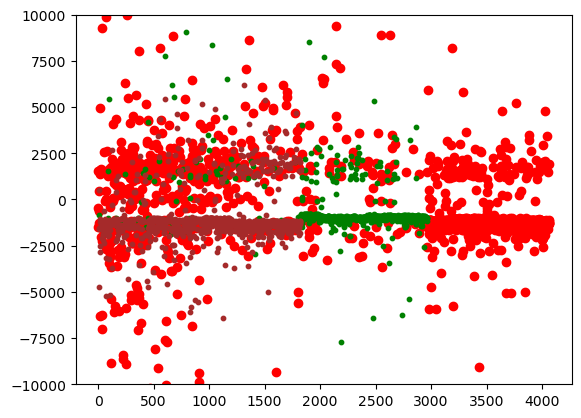

In [77]:
obj4_field_nan_min_max = obj4_field_nan[['diaObjectId','g_psfFluxMean', 'g_psfFluxMin', 'g_psfFluxMax', 'r_psfFluxMean', 'r_psfFluxMin', 'r_psfFluxMax', 'i_psfFluxMean', 'i_psfFluxMin', 'i_psfFluxMax']]

plt.scatter(np.arange(len(obj4_field_nan_min_max)), obj4_field_nan_min_max['r_psfFluxMean'].values, color='red')
plt.scatter(np.arange(len(obj4_field_nan_min_max)), obj4_field_nan_min_max['g_psfFluxMean'].values, s=10, color='g')
plt.scatter(np.arange(len(obj4_field_nan_min_max)), obj4_field_nan_min_max['i_psfFluxMean'].values, s=10, color='brown')
plt.ylim(-10000, 10000)

In [78]:
obj4_field_nan_min_max[obj4_field_nan_min_max['r_psfFluxMean']>1000]

,diaObjectId,g_psfFluxMean,g_psfFluxMin,g_psfFluxMax,r_psfFluxMean,r_psfFluxMin,r_psfFluxMax,i_psfFluxMean,i_psfFluxMin,i_psfFluxMax
153210,3068394109505896606,NaN,NaN,NaN,1518.954346,1518.954346,1518.954346,NaN,NaN,NaN
153293,3068394109505896700,NaN,NaN,NaN,1437.075562,1437.075562,1437.075562,NaN,NaN,NaN
153298,3068394109505896705,NaN,NaN,NaN,4969.968262,3656.614990,9012.880859,NaN,NaN,NaN
153313,3068394109505896723,NaN,NaN,NaN,1355.668823,1355.668823,1355.668823,NaN,NaN,NaN
153315,3068394109505896725,NaN,NaN,NaN,1581.683838,1581.683838,1581.683838,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
171406,3068394172869247095,NaN,NaN,NaN,1629.364624,1629.364624,1629.364624,NaN,NaN,NaN
171432,3068394172881829904,NaN,NaN,NaN,1935.905151,1935.905029,1935.905029,NaN,NaN,NaN
171439,3068394172881829934,NaN,NaN,NaN,3431.348633,3431.348877,3431.348877,NaN,NaN,NaN
171444,3068394172881829955,NaN,NaN,NaN,1486.537964,1486.538086,1486.538086,NaN,NaN,NaN


In [79]:
src4_field[['diaSourceId', 'raErr', 'decErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

,diaSourceId,raErr,decErr,psfFlux,band,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
0,3068394109514285084,NaN,NaN,-1946.655640,i,True,True,True,True,True
1,3068394109514285091,0.000006,0.000005,9831.191406,i,False,False,False,False,True
2,3068394109514285097,0.000005,0.000004,11874.484375,i,False,False,False,False,True
3,3068394109514285112,0.000027,0.000021,1254.862061,i,False,False,False,False,False
4,3068394109514285133,0.000016,0.000022,1797.926636,i,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
58246,3068394109510091044,0.000003,0.000003,26648.339844,i,False,False,False,False,False
58247,3068394109510091045,0.000005,0.000004,10978.866211,i,False,False,False,False,False
58248,3068394109510091046,0.000007,0.000008,3998.014160,i,False,False,False,False,True
58249,3068394109510091047,0.000012,0.000013,2391.240234,i,False,False,False,False,True


In [80]:
print(len(src4_field))

print(len(src4_field[ (src4_field['psfFlux']<0)]['raErr']))
print(len(src4_field[(src4_field['shape_flag']==True)]))
src_shape_negative = src4_field[(src4_field['shape_flag']==True) & (src4_field['psfFlux']<0)]['raErr']
print(len(src_shape_negative))
src_shape_negative[~np.isnan(src_shape_negative)].index
print(np.sum(np.isnan(src4_field['raErr'])))

58251
15782
29300
15778
16401


In [81]:
np.sum(np.isnan(src4_field['raErr']))

16401

In [82]:
src4_field[['diaSourceId', 'raErr', 'decErr', 'psfFlux', 'psfFluxErr', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']].loc[src_shape_negative[~np.isnan(src_shape_negative)].index]

,diaSourceId,raErr,decErr,psfFlux,psfFluxErr,band,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
1311,3068394109539451098,0.000366,0.000131,-1482.257935,233.992737,i,True,True,True,True,True
2152,3068394111670157475,0.000027,0.000037,-92.264366,216.773254,i,False,False,False,False,True
2311,3068394111674351700,0.000035,0.000073,-580.065918,232.914749,i,False,False,False,False,True
3885,3068394112743899273,0.000238,0.000072,-640.667603,224.214325,i,True,True,True,True,True
3903,3068394112743899298,0.000322,0.000090,-2063.958252,581.654968,i,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
53355,3068394129906991262,0.000851,0.001028,-291.092712,814.717468,i,False,False,False,False,True
54371,3068394123485511681,0.000076,0.000012,-1725.450439,374.449738,i,True,True,True,True,True
55145,3068394124542476388,0.000091,0.000020,-37.486374,237.978043,i,False,False,False,False,True
55606,3068394124571836466,0.000013,0.000029,-513.365417,264.827393,i,False,False,False,False,True


In [83]:
src_shape_negative = src4_field[(src4_field['shape_flag']==True) & (src4_field['psfFlux']>0)]['raErr']
src_shape_negative[~np.isnan(src_shape_negative)]

1        0.000006
2        0.000005
6        0.000022
21       0.000013
22       0.000004
           ...   
58237    0.000011
58241    0.000010
58243    0.000004
58248    0.000007
58249    0.000012
Name: raErr, Length: 12835, dtype: float64